In [219]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import pickle
from scipy.optimize import minimize

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [220]:
from Ising_integrals import *
from routines import *
from known_formulas import *

### Annealed vs RS

In [4]:
p = 3
n_points_m = 2_500
n_points_T = 7
n_points_more_T = 3

T_kauz, T_dyn = get_Tk_Td(p)

Teqs = np.hstack((np.linspace(T_kauz, T_dyn, n_points_T), T_dyn + (T_dyn - T_kauz) / (n_points_T) * np.arange(1, n_points_more_T + 1)))

es = -1 / (2 * Teqs)

In [6]:
file_path = f'./data/rs_p{p:d}.pkl'
if os.path.exists(file_path):
    print("Data is already saved.")

    with open(file_path, 'rb') as f:
        tmp = pickle.load(f)
        data = tmp['data']
        ms = tmp['ms']

    print("Data is loaded.")
else:
    print("Data is not saved.")

    ms = np.linspace(0.0, 0.999, n_points_m)
    data = observables((len(Teqs), n_points_m))
    
    for jdx, e in enumerate(tqdm(es, desc='RS')):
        for idx, m in enumerate(ms):
            h, q = fixed_points_h_q(m, e, p)

            data['q'][jdx, idx] = q
            data['h'][jdx, idx] = h
            data['T'][jdx, idx] = 1 / beta_q_e(q, m, e, p,h)
            data['delta_f'][jdx, idx] = deltaf_FP(m, q, h, p, e)
            data['s'][jdx, idx] = s_FP(m, q, h, p, e)
            data['dAT'][jdx, idx] = dAT_condition(
                q, m, h, beta_q_e(q, m, e, p,h), beta_q_e(q, m, e, p,h) / 2, p
            )

    with open(f'./data/rs_p{p:d}.pkl', 'wb') as f:
        pickle.dump({'data': data, 'ms': ms}, f)

    print("Data is saved.")

Data is not saved.


RS:   0%|          | 0/10 [00:00<?, ?it/s]

/Users/ghio/Desktop/fixed-energy-slice/Ising_integrals.py:197: RuntimeWarning: overflow encountered in cosh
  np.cosh(


ValueError: Fixed point iteration did not converge

In [5]:
s_anneald = np.empty((len(Teqs), len(ms)))
for jdx, e in enumerate(tqdm(es, desc="Annealed")):
    for idx, m in enumerate(ms):
        s_anneald[jdx, idx] = annealed_entropy(m, e, p)

Annealed:   0%|          | 0/10 [00:00<?, ?it/s]

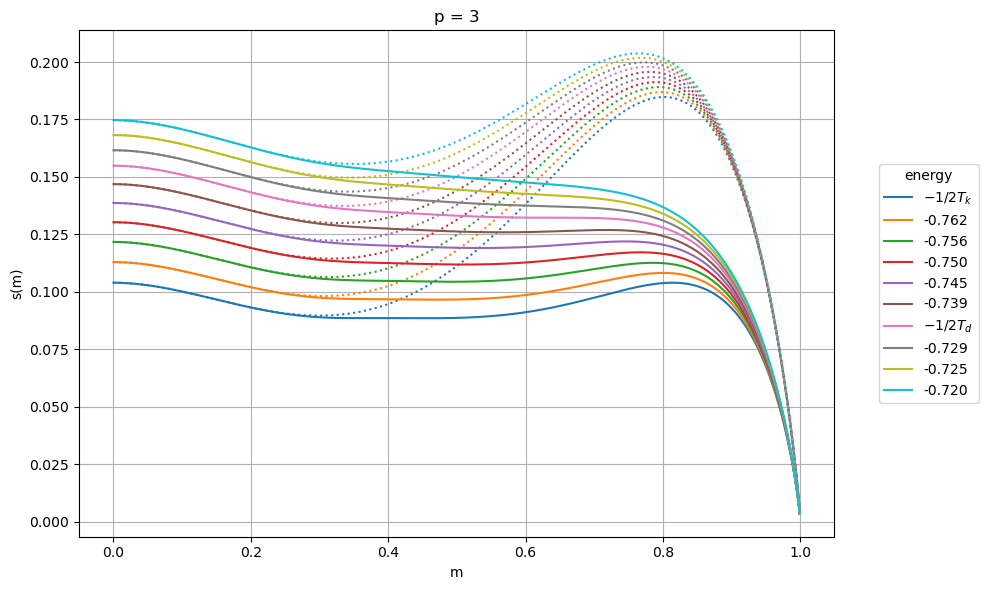

In [6]:
plt.figure(figsize=(10,6))
plt.title(f"p = {p:d}")
for i, e in enumerate(es):
    legend_name = legend_name_Tk_Td(e, T_kauz, T_dyn)

    plt.plot(ms, s_anneald[i], ':', color=f'C{i}')
    plt.plot(ms, data['s'][i], label=legend_name, color=f'C{i}')

plt.xlabel('m')
plt.ylabel(r's(m)')
lgd = plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), title="energy")
plt.grid()

plt.tight_layout()
plt.savefig(
    f"./imgs/annealed_vs_RS_p{p:d}.png",
    bbox_extra_artists=(lgd,),
    bbox_inches="tight",
    dpi=360,
)

In [34]:
0.5/np.sqrt(np.log(2))

0.6005612043932249

### Compute $e_{\rm sh}$ from first moment

#### Check

In [97]:
p = 100
n_points_m = 1_000
n_points_T = 10

Teqs = np.linspace(0.61 ,2, n_points_T)
es = -1 / (2 * Teqs)

In [98]:
s_anneald = np.empty((len(Teqs), len(ms)))
for jdx, e in enumerate(tqdm(es, desc="Annealed")):
    for idx, m in enumerate(ms):
        s_anneald[jdx, idx] = annealed_entropy(m, e, p)

Annealed:   0%|          | 0/10 [00:00<?, ?it/s]

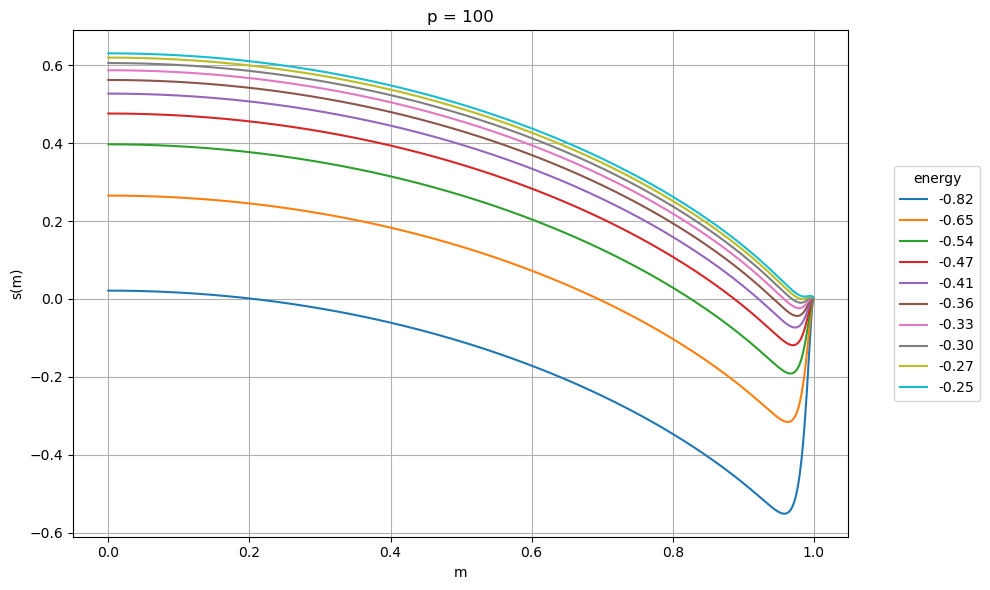

In [99]:
plt.figure(figsize=(10,6))
plt.title(f"p = {p:d}")
for i, e in enumerate(es):
    plt.plot(ms, s_anneald[i], color=f'C{i}', label=f'{es[i]:.2f}')

plt.xlabel('m')
plt.ylabel(r's(m)')
lgd = plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5), title="energy")
plt.grid()
#plt.xlim(0.95, 1)
#plt.ylim(-0.05, 0.1)

plt.tight_layout()

#### Computation

In [315]:
n_points_m = 50_000

In [316]:
def find_minimum_entropy(e, p, n_points_m):
    ms = np.linspace(1e-6, 1-1e-6, n_points_m)
    ders = np.array([deriv_ann_entropy(m, e, p) for m in ms])
    if deriv_ann_entropy(ms[np.argmin(ders)], e, p) > 0:
        m_min = 0.
    else:
        m_min = root_scalar(deriv_ann_entropy, args=(e, p), bracket=[1/n_points_m, ms[np.argmin(ders)]]).root
    return annealed_entropy(m_min, e, p)

In [319]:
np.unique(np.logspace(0.5,4,500,dtype=int))

array([    3,     4,     5,     6,     7,     8,     9,    10,    11,
          12,    13,    14,    15,    16,    17,    18,    19,    20,
          21,    22,    23,    24,    25,    26,    27,    28,    29,
          30,    31,    32,    33,    34,    35,    36,    37,    38,
          39,    40,    41,    42,    43,    44,    45,    46,    47,
          48,    49,    50,    51,    52,    53,    54,    55,    56,
          57,    58,    59,    60,    61,    62,    63,    64,    65,
          66,    68,    69,    70,    71,    72,    73,    74,    76,
          77,    78,    79,    81,    82,    83,    85,    86,    88,
          89,    90,    92,    93,    95,    97,    98,   100,   101,
         103,   105,   106,   108,   110,   112,   114,   115,   117,
         119,   121,   123,   125,   127,   129,   131,   134,   136,
         138,   140,   142,   145,   147,   150,   152,   155,   157,
         160,   162,   165,   168,   170,   173,   176,   179,   182,
         185,   188,

In [320]:
ps = np.unique(np.logspace(0.5,4,500,dtype=int))
ess = np.empty(len(ps))
for i,p in enumerate(tqdm(ps)):
    if (p==3): 
        ess[i] = root_scalar(find_minimum_entropy, args=(p, n_points_m), bracket=[-0.9, 0]).root
    else: 
        ess[i] = root_scalar(find_minimum_entropy, args=(p, n_points_m), bracket=[-0.81, 0]).root

  0%|          | 0/374 [00:00<?, ?it/s]

In [331]:
a,b = np.polyfit(np.log(1/ps[150:]), np.log(-ess[150:]), 1)

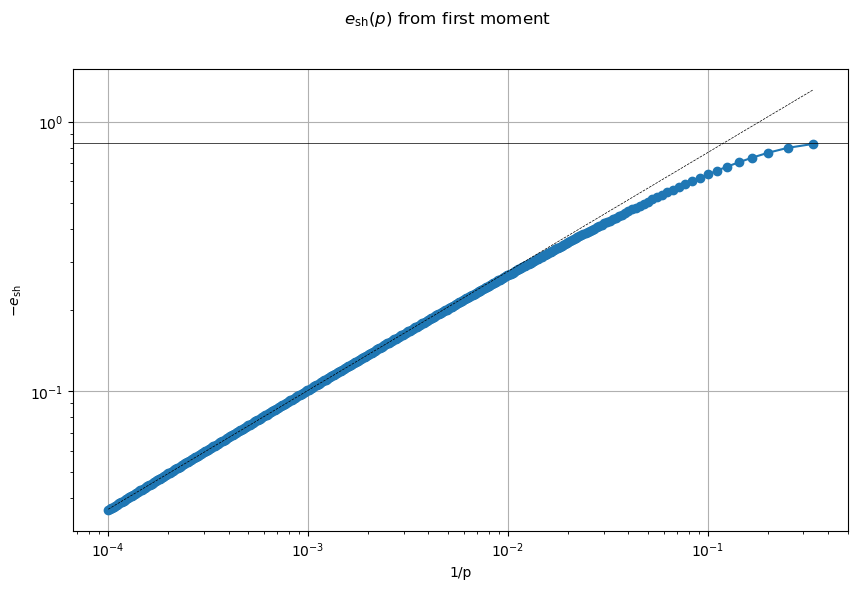

In [332]:
fig, ax = plt.subplots(figsize=(10,6))
fig.suptitle(r"$e_{\rm sh}(p)$ from first moment")
ax.plot(1/ps, -ess, '-o')
ax.axhline(np.sqrt(np.log(2)), color='black', lw=0.5)
ax.plot(1/ps, np.exp(b)*np.power(1/ps, a), '--', color='black', lw=0.5)
ax.set_xlabel('1/p')
ax.set_ylabel(r'$-e_{\rm sh}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()

In [333]:
a,b

(0.44188224583162694, 0.7553026998284301)

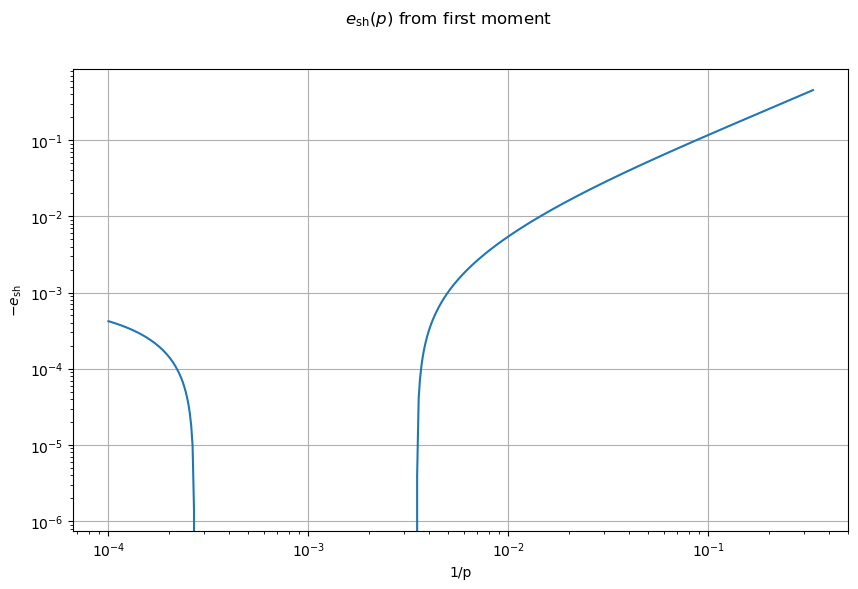

In [330]:
fig, ax = plt.subplots(figsize=(10,6))
fig.suptitle(r"$e_{\rm sh}(p)$ from first moment")
ax.plot(1/ps, np.exp(b)*np.power(1/ps, a)+ess, '-')
ax.set_xlabel('1/p')
ax.set_ylabel(r'$-e_{\rm sh}$')
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_yscale('symlog', linthresh=1e-5)
ax.grid()

#### Superimpose with Td from Franz-Parisi

In [325]:
#ps = np.arange(3,1003)
Tds = np.empty(len(ps))
for idx, p in enumerate(tqdm(ps)):
    Tds[idx] = compute_Td_standard(p)

  0%|          | 0/374 [00:00<?, ?it/s]

In [334]:
a_d,b_d = np.polyfit(np.log(1/ps[150:]), np.log(0.5/Tds[150:]), 1)

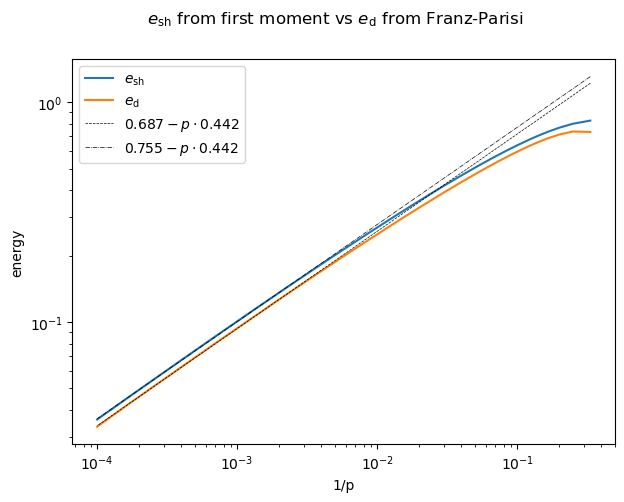

In [335]:
fig, ax = plt.subplots(figsize=(7,5))
fig.suptitle(r"$e_{\rm sh}$ from first moment vs $e_{\rm d}$ from Franz-Parisi")
ax.plot(1/ps, -ess, '-', label=r'$e_{\rm sh}$')
ax.plot(1/ps, 0.5/Tds, '-', label=r'$e_{\rm d}$')
ax.plot(1/ps, np.exp(b_d)*np.power(1/ps, a_d), '--', color='black', lw=0.5, label=f'${b_d:.3f} - p \cdot {a_d:.3f}$')
ax.plot(1/ps, np.exp(b)*np.power(1/ps, a), '-.', color='black', lw=0.5, label=f'${b:.3f} - p \cdot {a:.3f}$')
ax.set_xlabel('1/p')
ax.set_ylabel('energy')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
fig.savefig(f'./imgs/esh_vs_ed_.png', dpi=360)

In [277]:
a_d, b_d

(0.4300979408280449, 0.6072461814032247)

In [278]:
a,b

(0.429444296326294, 0.6753968723650652)